In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
from scipy.signal import find_peaks
# import ruptures as rpt
import time
import math
from scipy import ndimage as ndi
import plotly.io as pio
# from numba import njit
# from numba import jit, prange
from scipy.optimize import curve_fit
from scipy.stats import pearsonr

<span style="font-size: x-large;">Загрузка данных.</span>

In [2]:
# Путь к файлу
file_path =r'D:/DATA/DataR_CH0@V1725B_372_run1_Th228_14400s.csv'

In [3]:
start_time = time.time()
with open(file_path) as file:
    # Загружаем первые 100 000 строк
    run_0 = pd.read_csv(file, skiprows=range(1, 100000), nrows=100000)  # Для сокращения длины сигнала можно использовать usecols=range(3000)
end_time = time.time()

# Вывод времени выполнения
print("Время выполнения:", end_time - start_time, "секунд")

Время выполнения: 82.83275771141052 секунд


In [4]:
run_0.head(5)

0     1     2     3     4     5     6     7     8     9  ...   4990  \
0  9851  9851  9851  9851  9850  9850  9849  9849  9851  9851  ...   9984   
1  9851  9851  9853  9853  9848  9848  9854  9854  9854  9854  ...   9902   
2  9858  9858  9858  9858  9855  9855  9854  9854  9853  9853  ...  10007   
3  9905  9905  9902  9902  9901  9901  9902  9902  9902  9902  ...   9925   
4  9855  9855  9851  9851  9852  9852  9850  9850  9852  9852  ...  10253   

    4991   4992   4993   4994   4995   4996   4997   4998   4999  
0   9984   9986   9986   9985   9985   9985   9985   9984   9984  
1   9902   9903   9903   9902   9902   9901   9901   9902   9902  
2  10007  10009  10009  10006  10006  10006  10006  10005  10005  
3   9925   9930   9930   9930   9930   9930   9930   9929   9929  
4  10253  10250  10250  10248  10248  10248  10248  10251  10251  

[5 rows x 5000 columns]

<span style="font-size: x-large;">Мы точно знаем из характеристик АЦП, что сигналы с амплитудой больше 16000, являются перенасыщенными, их можно сразу удалить.</span>

In [5]:
start_time = time.time()

# Пороговое значение для перенасыщения
supersaturation = 16000

# Создание столбцов с максимальным значением и его индексом
run_0['max_value'] = run_0.max(axis=1)
run_0['index_max_value'] = run_0.idxmax(axis=1)

# Нахождение индексов строк с перенасыщением
index_glut = run_0[run_0['max_value'] > supersaturation].index.tolist()

# Создание нового DataFrame с "подчищенными" данными
clean_run_0 = run_0.drop(index=index_glut).copy()

# Сброс индексов и удаление столбца 'max_value'
clean_run_0.reset_index(drop=True, inplace=True)
clean_run_0.drop(['max_value', 'index_max_value'], axis=1, inplace=True)

# Удаление столбца с максимальным значением
# run_0.drop(['max_value'], axis= 1 , inplace= True)

# Вывод количества удаленных строк
print('Удалено строк:', len(index_glut))

end_time = time.time()
# Вывод времени выполнения
print("Время выполнения:", end_time - start_time, "секунд")

Удалено строк: 53
Время выполнения: 16.917877674102783 секунд


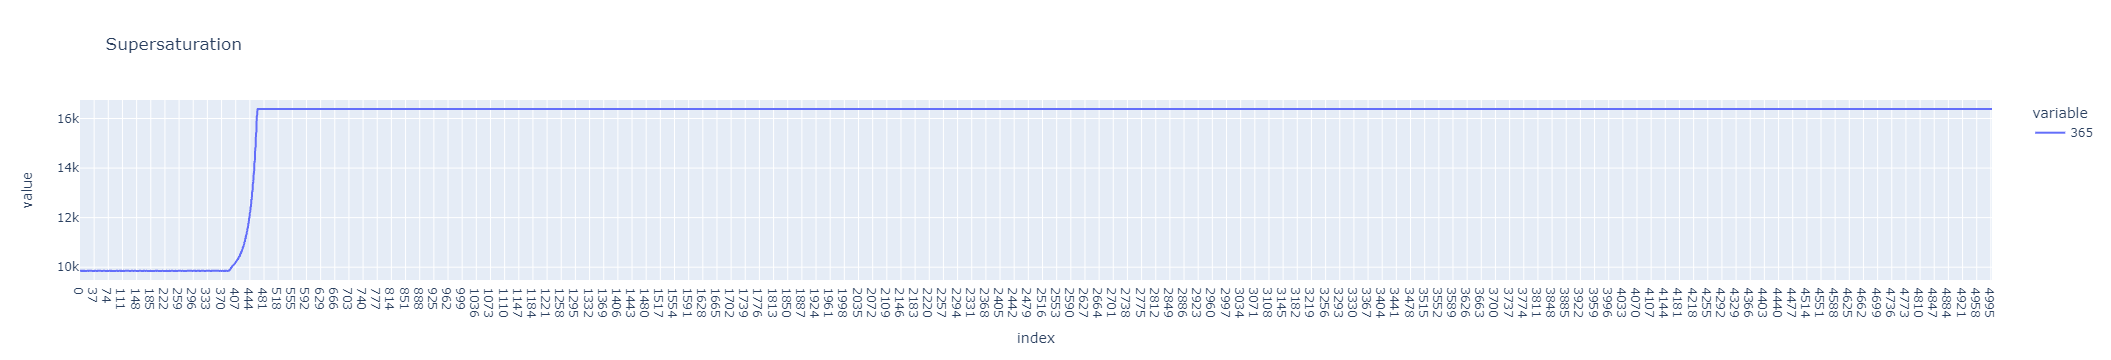

In [8]:
# Посмотрим график сигнала с перенасыщением
fig = px.line(run_0.iloc[index_glut[0]][0:4999], title='Supersaturation')
fig.show()

<span style="font-size: x-large;">Посмотрим на распределение максимальных значений сигналов.</span>

In [10]:
# Посмотрим гистограмму максимальных значений
fig = px.histogram(run_0['max_value'], title='Мax. value')
fig.show()

<span style="font-size: x-large;">Теперь взглянем на их время.</span>

In [13]:
run_0.dtypes

0                   int64
1                   int64
2                   int64
3                   int64
4                   int64
                    ...  
4997                int64
4998                int64
4999                int64
max_value           int64
index_max_value    object
Length: 5002, dtype: object

In [14]:
run_0['index_max_value'] = run_0['index_max_value'].astype(int)

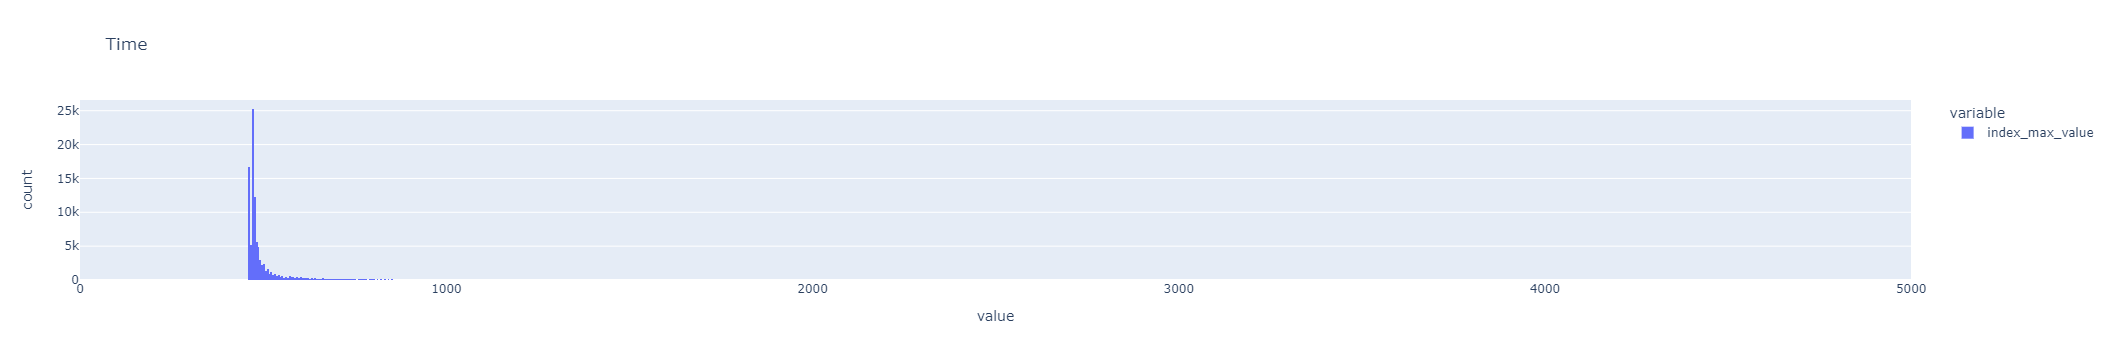

In [15]:
fig = px.histogram(run_0['index_max_value'], title='Time')
fig.show()

<span style="font-size: x-large;">Рассмотрим сигналы аплитуда которых по времени равняются нулю и которые находятся далешь 1000  кодов.</span>

In [16]:
run_0.query('index_max_value < 400')

0      1      2      3      4      5      6      7      8      9  \
9296   16383  16383  16383  16383  16383  16383  16383  16383  16383  16383   
28710  16383  16383  16383  16383  16383  16383  16383  16383  16383  16383   
34106  16383  16383  16383  16383  16383  16383  16383  16383  16383  16383   
36320  16383  16383  16383  16383  16383  16383  16383  16383  16383  16383   
39972  16383  16383  16383  16383  16383  16383  16383  16383  16383  16383   
50584  16383  16383  16383  16383  16383  16383  16383  16383  16383  16383   
53303  16383  16383  16383  16383  16383  16383  16383  16383  16383  16383   
66023  16383  16383  16383  16383  16383  16383  16383  16383  16383  16383   
85229  16383  16383  16383  16383  16383  16383  16383  16383  16383  16383   
91580  11264  11264  11267  11267  11262  11262  11255  11255  11258  11258   

       ...   4992   4993   4994   4995   4996   4997   4998   4999  max_value  \
9296   ...  14600  14600  14600  14600  14600  14600  14600  14600      16383   
28710  ...  14600  14600  14600  14600  14600  14600  14600  14600      16383   
34106  ...  14552  14552  14552  14552  14560  14560  14552  14552      16383   
36320  ...  14536  14536  14536  14536  14527  14527  14527  14527      16383   
39972  ...  14600  14600  14600  14600  14600  14600  14600  14600      16383   
50584  ...  14600  14600  14600  14600  14600  14600  14608  14608      16383   
53303  ...  14608  14608  14608  14608  14608  14608  14608  14608      16383   
66023  ...  14600  14600  14600  14600  14600  14600  14600  14600      16383   
85229  ...  14600  14600  14600  14600  14600  14600  14600  14600      16383   
91580  ...  10881  10881  10885  10885  10882  10882  10881  10881      11267   

       index_max_value  
9296                 0  
28710                0  
34106                0  
36320                0  
39972                0  
50584                0  
53303                0  
66023                0  
85229                0  
91580                2  

[10 rows x 5002 columns]

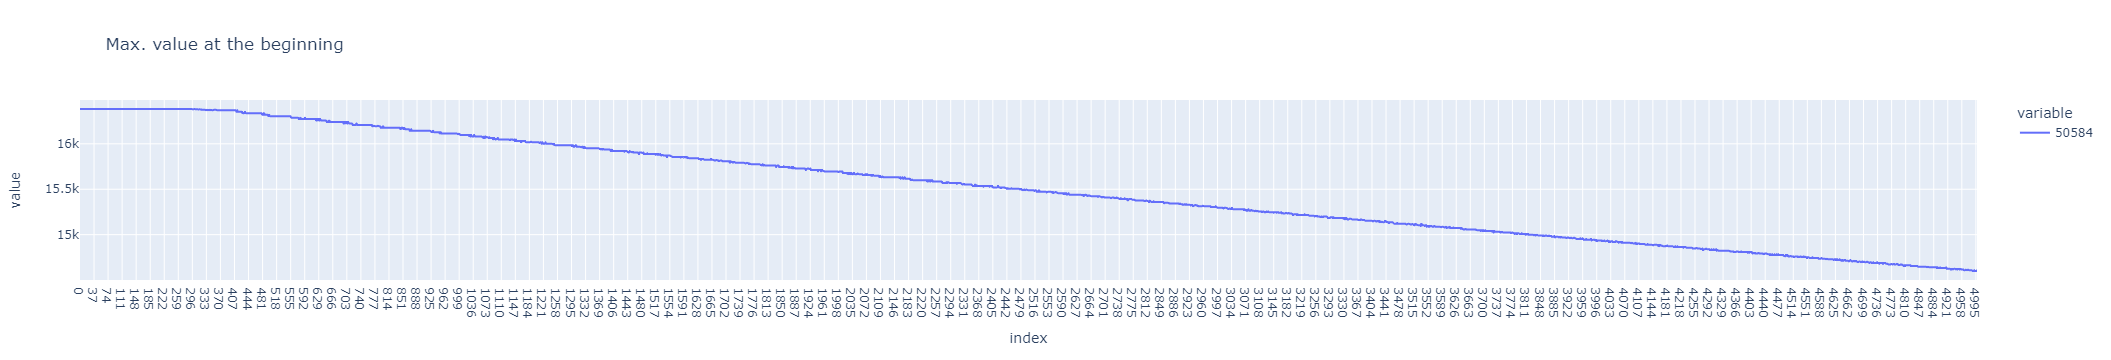

In [20]:
fig = px.line(run_0.iloc[50584][0:4999], title='Max. value at the beginning')
fig.show()

In [21]:
run_0.query('index_max_value > 1000')

0     1     2     3     4     5     6     7     8     9  ...   4992  \
12     9849  9849  9854  9854  9853  9853  9849  9849  9854  9854  ...   9893   
293    9853  9853  9855  9855  9853  9853  9851  9851  9851  9851  ...  10729   
352    9851  9851  9854  9854  9853  9853  9852  9852  9852  9852  ...   9896   
361    9854  9854  9852  9852  9854  9854  9853  9853  9853  9853  ...  10408   
366    9844  9844  9844  9844  9844  9844  9841  9841  9846  9846  ...  10551   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...    ...   
99609  9849  9849  9849  9849  9854  9854  9854  9854  9851  9851  ...   9885   
99641  9853  9853  9854  9854  9854  9854  9850  9850  9851  9851  ...  10163   
99709  9852  9852  9852  9852  9856  9856  9856  9856  9850  9850  ...   9939   
99865  9855  9855  9854  9854  9852  9852  9854  9854  9854  9854  ...  10010   
99963  9851  9851  9854  9854  9854  9854  9855  9855  9857  9857  ...  10460   

        4993   4994   4995   4996   4997   4998   4999  max_value  \
12      9893   9893   9893   9897   9897   9895   9895       9915   
293    10729  10730  10730  10729  10729  10731  10731      10862   
352     9896   9896   9896   9894   9894   9896   9896       9916   
361    10408  10411  10411  10406  10406  10403  10403      10420   
366    10551  10551  10551  10552  10552  10551  10551      10627   
...      ...    ...    ...    ...    ...    ...    ...        ...   
99609   9885   9881   9881   9886   9886   9887   9887       9903   
99641  10163  10166  10166  10170  10170  10166  10166      10245   
99709   9939   9941   9941   9939   9939   9941   9941       9975   
99865  10010  10007  10007  10009  10009  10013  10013      10056   
99963  10460  10457  10457  10458  10458  10460  10460      10647   

       index_max_value  
12                1018  
293               3322  
352               1066  
361               4856  
366               3808  
...                ...  
99609             1118  
99641             1978  
99709             1016  
99865             1810  
99963             1092  

[1285 rows x 5002 columns]

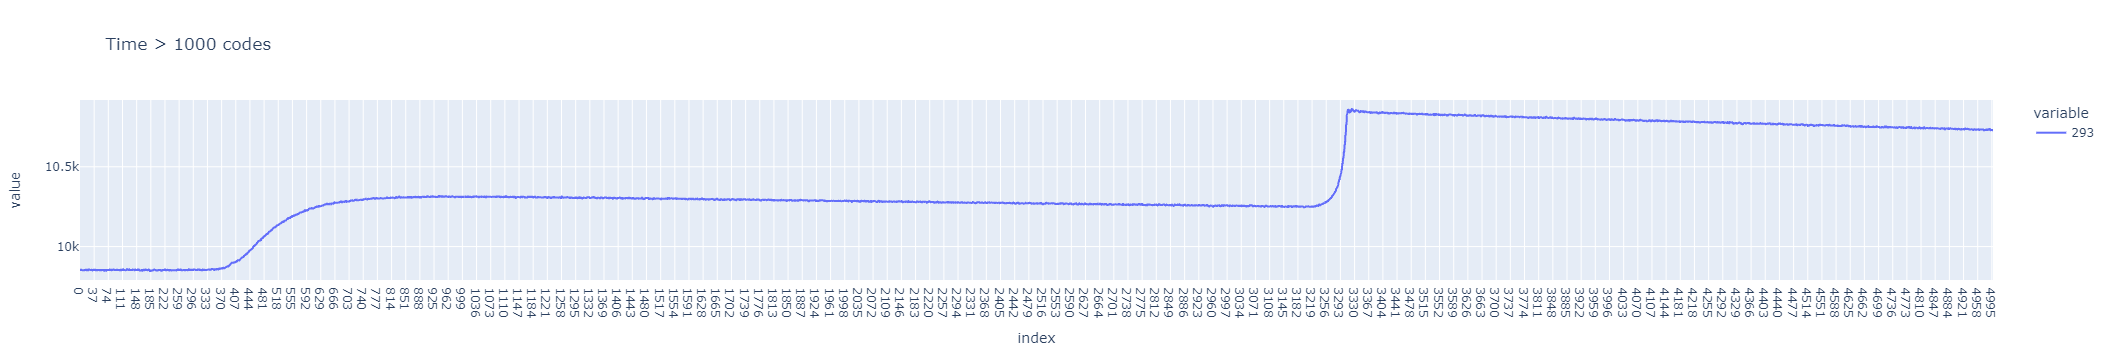

In [228]:
fig = px.line(run_0.iloc[293][0:4999], title='Time > 1000 codes')
fig.show()

In [36]:
run_0.query('index_max_value > 4800')

0     1     2     3     4     5     6     7     8     9  ...   4992  \
361    9854  9854  9852  9852  9854  9854  9853  9853  9853  9853  ...  10408   
3783   9853  9853  9854  9854  9852  9852  9850  9850  9854  9854  ...  10040   
6840   9853  9853  9855  9855  9854  9854  9852  9852  9855  9855  ...  10041   
8951   9850  9850  9852  9852  9855  9855  9852  9852  9854  9854  ...  10023   
15437  9851  9851  9853  9853  9854  9854  9854  9854  9854  9854  ...  10228   
22422  9850  9850  9855  9855  9857  9857  9854  9854  9851  9851  ...  10029   
24867  9859  9859  9856  9856  9853  9853  9857  9857  9853  9853  ...  10052   
29051  9847  9847  9853  9853  9850  9850  9852  9852  9854  9854  ...  10037   
30675  9852  9852  9850  9850  9852  9852  9851  9851  9851  9851  ...  10288   
35193  9854  9854  9852  9852  9853  9853  9852  9852  9851  9851  ...  10156   
39024  9856  9856  9856  9856  9857  9857  9854  9854  9852  9852  ...  10159   
40316  9852  9852  9849  9849  9852  9852  9854  9854  9850  9850  ...  10136   
44655  9855  9855  9853  9853  9857  9857  9854  9854  9853  9853  ...   9995   
44863  9854  9854  9853  9853  9850  9850  9851  9851  9853  9853  ...  10054   
48443  9852  9852  9854  9854  9850  9850  9849  9849  9856  9856  ...  10072   
49259  9854  9854  9858  9858  9854  9854  9853  9853  9855  9855  ...  10150   
52540  9852  9852  9852  9852  9851  9851  9852  9852  9854  9854  ...  10618   
63604  9853  9853  9854  9854  9853  9853  9851  9851  9851  9851  ...  10019   
65763  9849  9849  9853  9853  9852  9852  9853  9853  9849  9849  ...   9903   
67301  9852  9852  9853  9853  9850  9850  9848  9848  9850  9850  ...   9961   
68006  9854  9854  9853  9853  9855  9855  9856  9856  9851  9851  ...  10090   
68175  9855  9855  9850  9850  9852  9852  9851  9851  9850  9850  ...  10070   
71182  9884  9884  9881  9881  9880  9880  9881  9881  9878  9878  ...  10215   
76845  9848  9848  9853  9853  9853  9853  9854  9854  9854  9854  ...  10072   
78134  9849  9849  9850  9850  9852  9852  9852  9852  9854  9854  ...  10145   
78457  9853  9853  9855  9855  9854  9854  9855  9855  9852  9852  ...  10623   
78799  9851  9851  9848  9848  9855  9855  9852  9852  9855  9855  ...   9945   
80239  9851  9851  9852  9852  9854  9854  9853  9853  9853  9853  ...   9990   
81480  9854  9854  9854  9854  9849  9849  9846  9846  9851  9851  ...  10244   
82143  9847  9847  9851  9851  9852  9852  9850  9850  9852  9852  ...   9982   
82490  9864  9864  9866  9866  9866  9866  9866  9866  9865  9865  ...  10108   
82786  9850  9850  9849  9849  9850  9850  9853  9853  9853  9853  ...   9908   
89315  9853  9853  9853  9853  9853  9853  9852  9852  9848  9848  ...  10035   
91358  9852  9852  9855  9855  9849  9849  9854  9854  9852  9852  ...  11042   
92157  9859  9859  9861  9861  9864  9864  9859  9859  9859  9859  ...   9955   
94128  9854  9854  9854  9854  9851  9851  9853  9853  9851  9851  ...  10924   
94861  9851  9851  9853  9853  9852  9852  9850  9850  9852  9852  ...  10308   

        4993   4994   4995   4996   4997   4998   4999  max_value  \
361    10408  10411  10411  10406  10406  10403  10403      10420   
3783   10040  10038  10038  10042  10042  10042  10042      10045   
6840   10041  10041  10041  10043  10043  10040  10040      10045   
8951   10023  10026  10026  10028  10028  10027  10027      10029   
15437  10228  10227  10227  10228  10228  10230  10230      10236   
22422  10029  10036  10036  10043  10043  10050  10050      10050   
24867  10052  10050  10050  10047  10047  10048  10048      10056   
29051  10037  10037  10037  10041  10041  10038  10038      10045   
30675  10288  10286  10286  10290  10290  10289  10289      10292   
35193  10156  10156  10156  10155  10155  10156  10156      10164   
39024  10159  10161  10161  10160  10160  10158  10158      10169   
40316  10136  10136  10136  10137  10137  10136  10136      10145   
44655   9995   9993   9993   9995 

<span style="font-size: x-large;">Удалим дорожки сигналов, у которых значения базовой линии находятся выше, чем значения в хвосте сигнала.</span>

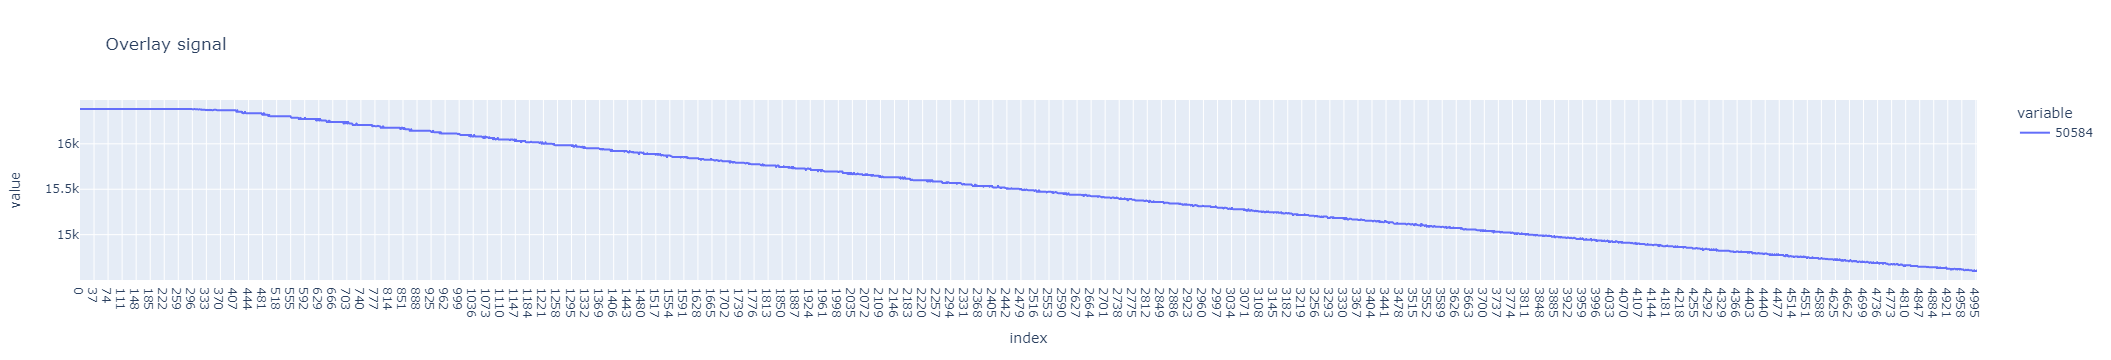

In [40]:
fig = px.line(run_0.iloc[50584][0:4999], title='Overlay signal')
fig.show()

In [41]:
# Удаление перекосившихся сигналов
index_falling_signal = clean_run_0[clean_run_0.iloc[:, 0] > clean_run_0.iloc[:, -1]].index.tolist()

# Удаление строк с перекосившим сигналом
clean_run_0 = clean_run_0.drop(index=index_falling_signal)

# Вывод количества удаленных строк
print('Удаленно строк:', len(index_falling_signal))

Удаленно строк: 395


<span style="font-size: x-large;">Удалим дорожки сигналов, у которых максимальное значение находится ближе к концу (index_max_value > 4800).</span>

In [42]:
# Удаление перекосившихся сигналов

clean_run_0['index_max_value'] = clean_run_0.idxmax(axis=1)
clean_run_0['index_max_value'] = clean_run_0['index_max_value'].astype(int)
index_double_signal = clean_run_0.query('index_max_value > 4800').index.tolist()

# Удаление строк с перекосившим сигналом
clean_run_0 = clean_run_0.drop(index=index_double_signal)

# Сброс индексов и удаление столбца 'max_value'
clean_run_0.reset_index(drop=True, inplace=True)
clean_run_0.drop(['index_max_value'], axis=1, inplace=True)

# Вывод количества удаленных строк
print('Удаленно строк:', len(index_double_signal))

Удаленно строк: 37


<span style="font-size: x-large;">В этом блоке мы будем вычислять разницу между текущим значением и значением, которое находится на 65 значений далее (если используется столбец, то это 65 строк выше в этом столбце) при помощи метода diff(). Затем мы будем использовать функцию find_peaks из модуля scipy.signal, чтобы определить количество пиков, удовлетворяющих заданным условиям. Если количество пиков равно двум или более, то мы запишем индекс этой вэйформы в список bad_signal.
Затем мы найдем значение максимальной амплитуды пика в каждой вэйформе и с помощью функции curve_fit из модуля scipy.optimize заложим его в фит Гауссом. После этого мы проанализируем полученные значения для дальнейшего отсева плохих сигналов.</span>

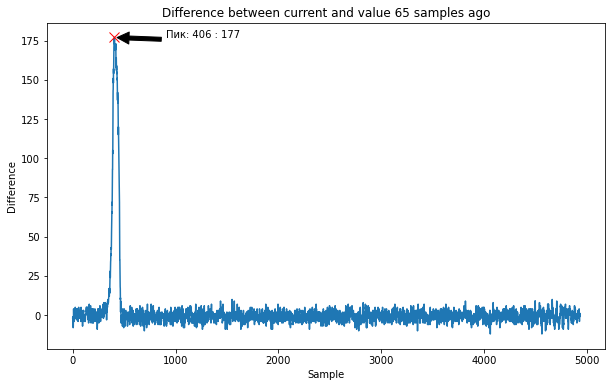

In [157]:
# Пример работы скрипта
row_number = 600
periods = 65

y = clean_run_0.iloc[row_number].diff(periods=periods)
y = y.iloc[periods:]
x = np.array([i for i in range(len(y))])

# Определяем амплитуду и центр пика
threshold = (np.max(y) - np.min(y))/2 + np.min(y)
peaks, _ = find_peaks(y, height=threshold, distance=150)
peak = peaks[0]
ampl = int(y[peaks[0]])

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x, y)
ax.set_xlabel('Sample')
ax.set_ylabel('Difference')
ax.set_title(f'Difference between current and value {periods} samples ago')
plt.annotate('Пик: '+str(peak)+' : '+str(ampl), xy=(peak, ampl), xytext=(peak+500, ampl),
             arrowprops=dict(facecolor='black', shrink=0.05))

# Отмечаем пики на графике
peaks, _ = find_peaks(y, height=threshold, distance=150)
ax.plot(x[peaks], y[peaks], "x", color='red', markersize=10)

plt.show()

# print('Координаты пика: '+str(peak)+':'+str(ampl)+'')

In [158]:
# Определение функции гауссиана
def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-0.5 * ((x - mean) / stddev)**2)

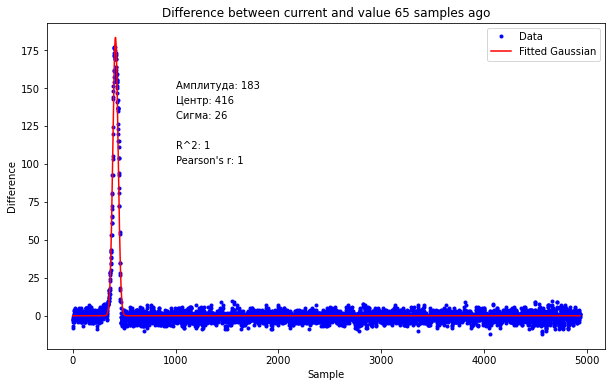

In [159]:
# Подгонка данных с помощью curve_fit
initial_guess = [ampl, peak, 100]  # Начальные значения параметров
params, covariance = curve_fit(gaussian, x, y, p0=initial_guess)

# Получение подогнанных значений
y_fit = gaussian(x, *params)

# Расчет среднеквадратичной ошибки (MSE)
mse = np.mean((y - y_fit)**2)

# Расчет Коэффициента корреляции (Pearson's r)
r, _ = pearsonr(y, y_fit)

# Расчет R-квадрат (R^2)
ssr = np.sum((y - y_fit)**2)
sst = np.sum((y - np.mean(y))**2)
r_squared = 1 - (ssr / sst)

# Визуализация результатов с заданными значениями на оси X
fig, ax = plt.subplots(figsize=(10, 6))

plt.plot(x, y, 'b.', label='Data')
plt.plot(x, y_fit, 'r', label='Fitted Gaussian')
ax.text(1000, 150, r'Амплитуда: '+str(round(params[0]))+'')
ax.text(1000, 140, r'Центр: '+str(round(params[1]))+'')
ax.text(1000, 130, r'Сигма: '+str(round(params[2]))+'')
ax.text(1000, 110, r'R^2: '+str(round(r_squared))+'')
ax.text(1000, 100, r"Pearson's r: "+str(round(r_squared))+"")
plt.legend()
plt.xlabel('Sample')
plt.ylabel('Difference')
plt.title(f'Difference between current and value {periods} samples ago')

plt.show()

# print('Амплитуда:', params[0])
# print('Центр:', params[1])
# print('Сигма:', params[2])

In [44]:
# Создание списка для сохранения результатов
bad_signal = []
data_fit = []
periods = 65  # Установите нужное значение periods
counter = 0

start_time = time.time()

# Перебираем каждую строку DataFrame
for index, row in clean_run_0.iterrows():
#     row = row.iloc[:2500]
    counter += 1
    y = row.diff(periods=periods)
    threshold = (np.max(y) - np.min(y))/2 + np.min(y)
    peaks, _ = find_peaks(y, height=threshold, distance=150)
    
    if len(peaks) >= 2:
        index_bad_signal = index
        bad_signal.append({
        'index_bad_signal': index
        })
    else:
        
        
        center = int(row.diff(periods=periods).idxmax()) #индекс самого большого значения
        amplitude = row.diff(periods=periods)[center] #значение амплитуды
        sigma = 100
    
        y = y.iloc[periods:]
        x = np.array([i for i in range(len(y))])

        # Подгонка данных с помощью curve_fit
        initial_guess = [amplitude, center, sigma]  # Начальные значения параметров
        params, covariance = curve_fit(gaussian, x, y, p0=initial_guess)
        
        if params[2] < 0:
            while params[2] < 0 and sigma < 1000:
                sigma += 1
                initial_guess = [amplitude, center, sigma]
                params, covariance = curve_fit(gaussian, x, y, p0=initial_guess)
            

        # Получение подогнанных значений
        y_fit = gaussian(x, *params)
    
        #Расчет начала подъема
        width_within_3_sigma = 2 * 3 * params[2] # Ширина в пределах 3σ
        index_start_rise = round(params[1] - (width_within_3_sigma / 2) + periods)
        value_start_rise = row.iloc[index_start_rise]
    
        # Расчет среднеквадратичной ошибки (MSE)
        mse = np.mean((y - y_fit)**2)
    
        # Расчет хи-квадрат
        residuals = y - y_fit
        chi_square = np.sum((residuals / np.sqrt(y_fit))**2)
    
        # Расчет Коэффициента корреляции (Pearson's r)
        r, _ = pearsonr(y, y_fit)

        # Расчет R-квадрат (R^2)
        ssr = np.sum((y - y_fit)**2)
        sst = np.sum((y - np.mean(y))**2)
        r_squared = 1 - (ssr / sst)

        # Добавление результатов в список
        data_fit.append({
        'index_start_rise': index_start_rise,
        'value_start_rise': value_start_rise,
        'amplitude': params[0],
        'center': params[1],
        'sigma': params[2],
        'chi_square': chi_square,
        'mse': mse,
        'pearson_r': r,
        'r_squared': r_squared
    })

# # Создание DataFrame из списка результатов
data_fit = pd.DataFrame(data_fit)

# Рассчитываем время выполнения
finish_time = time.time()
print(finish_time - start_time)


1114.1005895137787


In [47]:
data_fit

index_start_rise  value_start_rise   amplitude      center      sigma  \
0                   404              9860  185.380170  415.629235  25.659906   
1                   404              9853   71.064594  415.776753  25.431034   
2                   404              9863  216.152918  415.476960  25.599832   
3                   404              9902   59.665864  414.466859  25.303404   
4                   401              9856  516.194274  419.662593  27.960449   
...                 ...               ...         ...         ...        ...   
99101               407              9852  182.723670  420.429446  26.192126   
99102               403              9865  219.854688  415.954719  25.818822   
99103               399              9853  401.898374  429.206884  31.807718   
99104               404              9851   60.424550  414.973007  25.325110   
99105               403              9871  561.963986  415.761828  25.754592   

       chi_square        mse  pearson_r  r_squared  
0             inf  14.966515   0.977702   0.954464  
1             inf   8.364663   0.919976   0.845215  
2             inf  17.346275   0.980953   0.960830  
3             inf   8.794622   0.888624   0.785585  
4             inf  36.099499   0.994080   0.986552  
...           ...        ...        ...        ...  
99101         inf   9.731338   0.985554   0.969674  
99102         inf  17.296595   0.981856   0.962506  
99103         inf  35.309055   0.991419   0.981007  
99104         inf   8.523961   0.891793   0.794182  
99105         inf  74.931886   0.988046   0.974756  

[99106 rows x 9 columns]

In [166]:
bad_signal = pd.DataFrame(bad_signal)

In [172]:
# bad_signal = bad_signal[0].tolist()

In [175]:
clean_run_0 = clean_run_0.drop(index=bad_signal).copy()
clean_run_0.reset_index(drop=True, inplace=True)

In [178]:
clean_run_0.shape

(99106, 5000)

In [181]:
start_time = time.time()
data_amplitude = []

for index, row in clean_run_0.iterrows():
    index_amplitude = int(row.diff(periods=periods).idxmax())
    amplitude = row.iloc[index_amplitude]
    data_amplitude.append({
        'index_amplitude': index_amplitude,
        'amplitude_diff': amplitude})


data_amplitude = pd.DataFrame(data_amplitude)
end_time = time.time()
print(end_time - start_time)

27.30056858062744


In [182]:
data_amplitude

index_amplitude  amplitude_diff
0                  465           10038
1                  477            9927
2                  466           10069
3                  462            9964
4                  494           10405
...                ...             ...
99101              480           10036
99102              465           10076
99103              502           10342
99104              464            9914
99105              464           10419

[99106 rows x 2 columns]

In [183]:
# Соединяем две таблицы, чтобы у нас было значения амплитуд полученных двумя разными способами
work_data = data_fit.merge(data_amplitude, left_index=True, right_index=True)

In [184]:
# Находим время подъема
work_data['rise_time'] = work_data['index_amplitude'] - work_data['index_start_rise']

In [185]:
work_data

index_start_rise  value_start_rise   amplitude      center      sigma  \
0                   404              9860  185.380170  415.629235  25.659906   
1                   404              9853   71.064594  415.776753  25.431034   
2                   404              9863  216.152918  415.476960  25.599832   
3                   404              9902   59.665864  414.466859  25.303404   
4                   401              9856  516.194274  419.662593  27.960449   
...                 ...               ...         ...         ...        ...   
99101               407              9852  182.723670  420.429446  26.192126   
99102               403              9865  219.854688  415.954719  25.818822   
99103               399              9853  401.898374  429.206884  31.807718   
99104               404              9851   60.424550  414.973007  25.325110   
99105               403              9871  561.963986  415.761828  25.754592   

       chi_square        mse  pearson_r  r_squared  index_amplitude  \
0             inf  14.966515   0.977702   0.954464              465   
1             inf   8.364663   0.919976   0.845215              477   
2             inf  17.346275   0.980953   0.960830              466   
3             inf   8.794622   0.888624   0.785585              462   
4             inf  36.099499   0.994080   0.986552              494   
...           ...        ...        ...        ...              ...   
99101         inf   9.731338   0.985554   0.969674              480   
99102         inf  17.296595   0.981856   0.962506              465   
99103         inf  35.309055   0.991419   0.981007              502   
99104         inf   8.523961   0.891793   0.794182              464   
99105         inf  74.931886   0.988046   0.974756              464   

       amplitude_diff  rise_time  
0               10038         61  
1                9927         73  
2               10069         62  
3                9964         58  
4               10405         93  
...               ...        ...  
99101           10036         73  
99102           10076         62  
99103           10342        103  
99104            9914         60  
99105           10419         61  

[99106 rows x 12 columns]

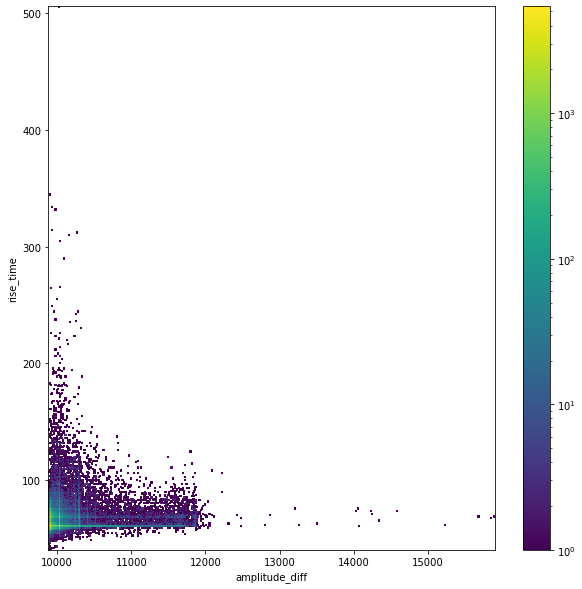

In [189]:
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import numpy as np

#normal distribution center at x=0 and y=5
plt.figure(figsize=(10, 10))
y = work_data['rise_time']
x = work_data['amplitude_diff']

h = plt.hist2d(x, y, bins=400, norm=LogNorm()) 
plt.ylabel('rise_time')   
plt.xlabel('amplitude_diff')
plt.colorbar(h[3])
# plt.xlim(9850, 12500)
# plt.ylim(35, 150)

In [211]:
# Взгляним на сигналы, у которых время подъема больше 100 

work_data.query('rise_time > 100')

index_start_rise  value_start_rise   amplitude      center      sigma  \
204                 402              9854  203.190089  439.384283  34.096836   
241                 371              9856   69.334496  444.104051  46.153270   
329                 399              9853  171.548067  430.886602  32.233724   
586                 393              9852  134.102191  435.368121  35.628901   
649                 399              9862   72.089855  436.522796  34.071759   
...                 ...               ...         ...         ...        ...   
98847               329              9849   98.854592  446.325034  60.724541   
98972               403              9856  340.059815  442.349489  34.624142   
99018               397              9849   75.286077  460.446168  42.818642   
99070               325              9856  262.850926  449.312134  63.068762   
99103               399              9853  401.898374  429.206884  31.807718   

       chi_square         mse  pearson_r  r_squared  index_amplitude  \
204           inf   16.114888   0.985313   0.968740              506   
241           inf   17.542106   0.904375   0.816533              510   
329           inf   14.557459   0.980043   0.958558              502   
586           inf   12.388242   0.974905   0.948288              504   
649           inf    9.462034   0.933464   0.869176              510   
...           ...         ...        ...        ...              ...   
98847         inf   19.620404   0.956178   0.913233              484   
98972         inf   38.397979   0.987852   0.973675              510   
99018         inf   12.450848   0.935840   0.873325              531   
99070         inf  247.081595   0.926716   0.858685              496   
99103         inf   35.309055   0.991419   0.981007              502   

       amplitude_diff  rise_time  
204             10077        104  
241              9938        139  
329             10062        103  
586             10032        111  
649              9946        111  
...               ...        ...  
98847            9979        155  
98972           10298        107  
99018            9976        134  
99070           10228        171  
99103           10342        103  

[1261 rows x 12 columns]

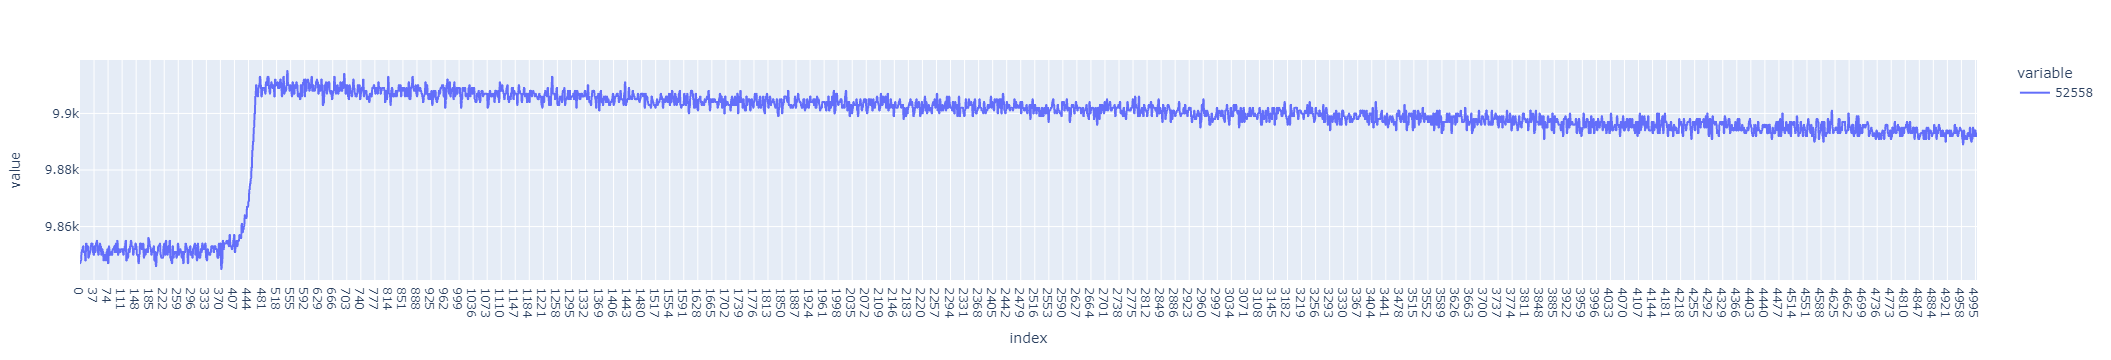

In [262]:
px.line(clean_run_0.iloc[52558])

In [212]:
# Удаляем сигналы, у которых время подъема больше 100

index_big_rise_time = work_data.query('rise_time > 100').index.tolist()

In [214]:
work_data = work_data.drop(index=index_big_rise_time).copy()
work_data.reset_index(drop=True, inplace=True)

In [215]:
clean_run_0 = clean_run_0.drop(index=index_big_rise_time).copy()
clean_run_0.reset_index(drop=True, inplace=True)

In [220]:
print(work_data.shape[0] == clean_run_0.shape[0])

True


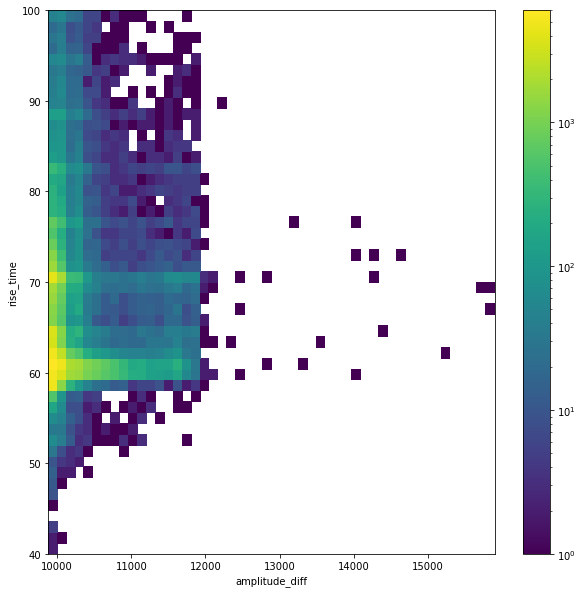

In [225]:
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import numpy as np

#normal distribution center at x=0 and y=5
plt.figure(figsize=(10, 10))
y = work_data['rise_time']
x = work_data['amplitude_diff']

h = plt.hist2d(x, y, bins=50, norm=LogNorm()) 
plt.ylabel('rise_time')   
plt.xlabel('amplitude_diff')
plt.colorbar(h[3])
# plt.xlim(9850, 12500)
# plt.ylim(35, 150)

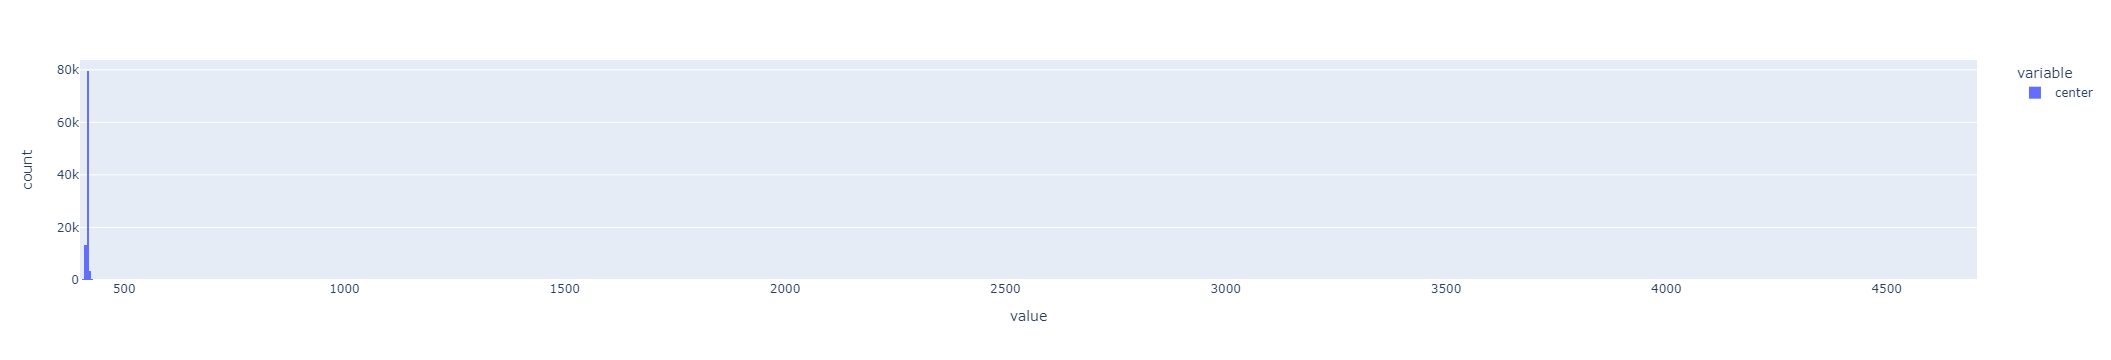

In [230]:
# Построим гистограмму по значению центра, взятого из фитирования
px.histogram(work_data['center'])

In [236]:
work_data.query('center > 1000')

index_start_rise  value_start_rise    amplitude       center  \
289                3253             10277   609.163060  3264.231346   
367                4576              9898   191.692063  4588.166097   
1882               2903              9920   891.633055  2916.832691   
2824               2390             10594  1946.659780  2404.374401   
3015               2012             10180   916.862069  2023.731460   
...                 ...               ...          ...          ...   
95626              3442              9911   182.535905  3455.199590   
96076              4459              9899   348.886288  4464.964664   
96130              3255              9921   383.809186  3267.295865   
96406              2715              9922   465.407641  2727.327119   
97715              1728              9908   147.950160  1740.464101   

           sigma  chi_square          mse  pearson_r  r_squared  \
289    25.541799         inf   663.820253   0.913652   0.831250   
367    25.747174         inf    35.476868   0.950633   0.903362   
1882   26.420183         inf   112.469487   0.992635   0.985089   
2824   26.471307         inf  6213.970977   0.922012   0.849911   
3015   25.692235         inf  1178.863470   0.930439   0.865655   
...          ...         ...          ...        ...        ...   
95626  25.923538         inf    59.568189   0.914269   0.835542   
96076  23.605069         inf    81.140026   0.962215   0.925812   
96130  25.621923         inf   102.088466   0.963695   0.928703   
96406  25.760891         inf    84.825090   0.979201   0.958754   
97715  25.873512         inf    42.085033   0.908632   0.825556   

       index_amplitude  amplitude_diff  rise_time  
289               3312           10857         59  
367               4636           10082         60  
1882              2972           10810         69  
2824              2460           12437         70  
3015              2072           11048         60  
...                ...             ...        ...  
95626             3504           10090         62  
96076             4527           10206         68  
96130             3316           10302         61  
96406             2776           10374         61  
97715             1793           10053         65  

[204 rows x 12 columns]

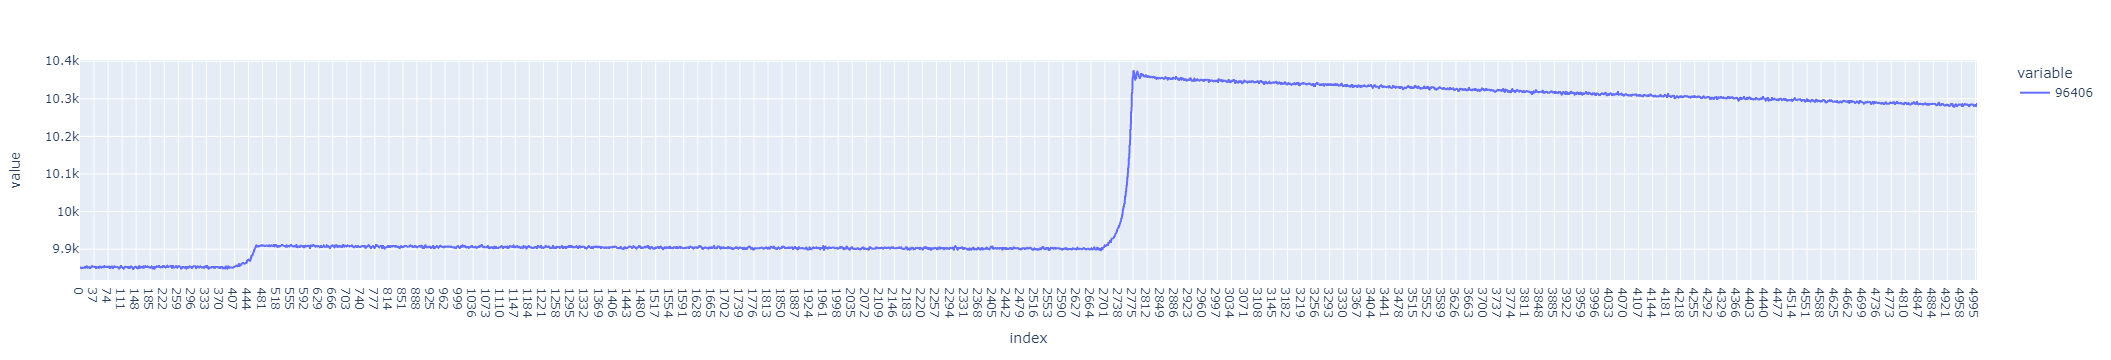

In [242]:
px.line(clean_run_0.iloc[96406])

In [243]:
index_big_center = work_data.query('center > 1000').index.tolist()

In [244]:
work_data = work_data.drop(index=index_big_center).copy()
work_data.reset_index(drop=True, inplace=True)

In [245]:
clean_run_0 = clean_run_0.drop(index=index_big_center).copy()
clean_run_0.reset_index(drop=True, inplace=True)

In [246]:
print(work_data.shape[0] == clean_run_0.shape[0])

True


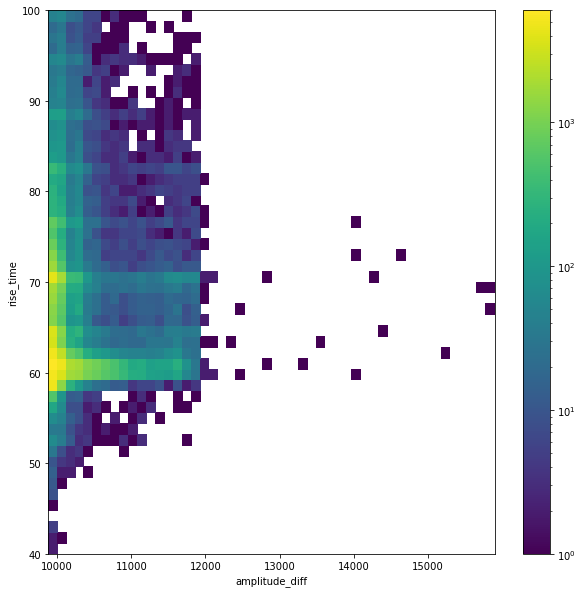

In [247]:
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import numpy as np

#normal distribution center at x=0 and y=5
plt.figure(figsize=(10, 10))
y = work_data['rise_time']
x = work_data['amplitude_diff']

h = plt.hist2d(x, y, bins=50, norm=LogNorm()) 
plt.ylabel('rise_time')   
plt.xlabel('amplitude_diff')
plt.colorbar(h[3])
# plt.xlim(9850, 12500)
# plt.ylim(35, 150)

In [261]:
print('Количество отфильтрованных вейвформ =', run_0.shape[0] - clean_run_0.shape[0])
print('В процентах: '+str(round((100 - clean_run_0.shape[0] * 100 / run_0.shape[0]), 2))+'%')

Количество отфильтрованных вейвформ = 2359
В процентах: 2.36%
